## Evaluations of Bering Sea ADCP Data 

### Example step by step for one site

In [25]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np
import xarray as xr
import datetime

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

server_url='http://akutan.pmel.noaa.gov:8080/erddap'
dataset = 'ADCP_Mooring_18bsp8a_final'


e = ERDDAP(server=server_url)

e.constraints = None
e.protocol = 'griddap'

opendap_url = e.get_download_url(
    dataset_id=dataset,
    response='opendap',
)

print(opendap_url)

http://akutan.pmel.noaa.gov:8080/erddap/griddap/ADCP_Mooring_18bsp8a_final


In [17]:
from netCDF4 import Dataset

with Dataset(opendap_url) as nc:
    print(nc.summary)

QC'd (final) Gridded ADCP Vel Data from 18BSP-8A


In [4]:
e.dataset_id=dataset
e.response = 'nc'
ds = e.to_xarray(decode_times=True)

get second to last index (so 2 bin from bottom)

In [5]:
depth_curr = ds.isel(depth=ds.depth.size-2)

In [6]:
depth_curr

<xarray.Dataset>
Dimensions:    (latitude: 1, longitude: 1, time: 8348)
Coordinates:
  * time       (time) datetime64[ns] 2018-10-11 ... 2019-09-23T19:00:00
    depth      float64 52.0
  * latitude   (latitude) float32 62.19
  * longitude  (longitude) float64 185.3
Data variables:
    v_1206     (time, latitude, longitude) float32 ...
    u_1205     (time, latitude, longitude) float32 ...
    w_1204     (time, latitude, longitude) float32 ...
    Werr_1201  (time, latitude, longitude) float32 ...
Attributes: (12/37)
    cdm_data_type:                 Grid
    COMPOSITE:                     1
    Conventions:                   COARDS, CF-1.6, ACDD-1.3
    CREATION_DATE:                 March 23, 2021 16:53 UTC
    creation_date:                 April 16, 2020 21:06 UTC
    DATA_CMNT:                     22019.VEL
    ...                            ...
    time_coverage_end:             2019-09-23T19:00:00Z
    time_coverage_start:           2018-10-11T00:00:00Z
    title:                         QC'd (final) ADCP Vel Data from 18BSP-8A
    WATER_DEPTH:                   73.0
    WATER_MASS:                    B
    Westernmost_Easting:           185.31576538085938

In [18]:
### final only with filtered data
import sys
try:
    # The insertion index should be 1 because index 0 is this file
    sys.path.insert(1, '/Users/bell/Programs/Python/EcoFOCI_Jupyter_Notebooks/filters')  # the type of path is string
    # because the system path already have the absolute path to folder a
    # so it can recognize file_a.py while searching 
    import lanzcos
except (ModuleNotFoundError, ImportError) as e:
    print("{} fileure".format(type(e)))
else:
    print("Import succeeded")

Import succeeded


In [8]:

udata = depth_curr.u_1205[:,0,0].to_pandas()
vdata = depth_curr.v_1206[:,0,0].to_pandas()

data = pd.concat([udata, vdata], axis=1)
data.columns = ['udata','vdata']

data['udata'][data.udata > 1e34]=np.nan
data['vdata'][data.vdata > 1e34]=np.nan
data = data.resample('1H').mean()

## missing data fill limited by number of hours to linearly interpolate
data['tempu'] = data['udata'].interpolate(method='time',limit=6)
data['tempv'] = data['vdata'].interpolate(method='time',limit=6)

# get index of missing data that wasn't filled
# the remaining missing data will continue to be missing after analysis
# this data and the edges of the timeseries need to have the effects of the filter window accounted for

missing_index_u = np.isnan(data.tempu)
missing_index_v = np.isnan(data.tempv)
data['tempu'] = data['udata'].interpolate(method='time')
data['tempv'] = data['vdata'].interpolate(method='time')

#filter data with rudimentary matlab script
data['ufdata'] = lanzcos.lanzcos(data.tempu.values,1,35)+data['udata'].mean()
data['vfdata'] = lanzcos.lanzcos(data.tempv.values,1,35)+data['vdata'].mean()
data['ufdata'][missing_index_u] = np.nan
data['vfdata'][missing_index_v] = np.nan    



<ipython-input-8-fe5b8713f2a9>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ufdata'][missing_index_u] = np.nan
<ipython-input-8-fe5b8713f2a9>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['vfdata'][missing_index_v] = np.nan


In [9]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmocean
print(cmocean.cm.cmapnames)

from matplotlib.dates import (
    YearLocator,
    WeekdayLocator,
    MonthLocator,
    DayLocator,
    HourLocator,
    DateFormatter,
)
import matplotlib.ticker as ticker

['thermal', 'haline', 'solar', 'ice', 'gray', 'oxy', 'deep', 'dense', 'algae', 'matter', 'turbid', 'speed', 'amp', 'tempo', 'rain', 'phase', 'topo', 'balance', 'delta', 'curl', 'diff', 'tarn']


<AxesSubplot:xlabel='time'>

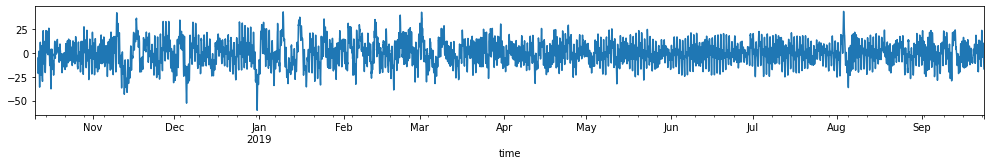

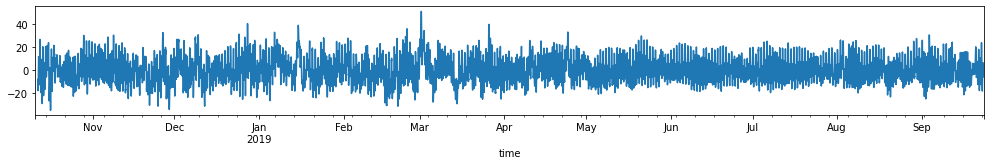

In [10]:

fig, ax = plt.subplots(figsize=(17, 2))
data.udata.plot(ax=ax)
data.ufdata.plot(ax=ax,color='r')

fig, ax = plt.subplots(figsize=(17, 2))
data.vdata.plot(ax=ax)
data.vfdata.plot(ax=ax,color='r')



In [11]:
class Timeseries1dStickPlot(object):

    mpl.rcParams['svg.fonttype'] = 'none'
    mpl.rcParams['ps.fonttype'] = 42
    mpl.rcParams['pdf.fonttype'] = 42
    
    def __init__(self, fontsize=10, labelsize=10, plotstyle='k-.', stylesheet='bmh'):
        """Initialize the timeseries with items that do not change.

        This sets up the axes and station locations. The `fontsize` and `spacing`
        are also specified here to ensure that they are consistent between individual
        station elements.

        Parameters
        ----------
        fontsize : int
            The fontsize to use for drawing text
        labelsize : int
          The fontsize to use for labels
        stylesheet : str
          Choose a mpl stylesheet [u'seaborn-darkgrid', 
          u'seaborn-notebook', u'classic', u'seaborn-ticks', 
          u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', 
          u'ggplot', u'fivethirtyeight', u'seaborn-colorblind', 
          u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', 
          u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', 
          u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', 
          u'seaborn-dark-palette']
        """

        self.fontsize = fontsize
        self.labelsize = labelsize
        self.plotstyle = plotstyle
        plt.style.use(stylesheet)

    @staticmethod
    def add_title(mooringid='',lat=-99.9,lon=-99.9,depth=9999,instrument=''):
      """Pass parameters to annotate the title of the plot

      This sets the standard plot title using common meta information from PMEL/EPIC style netcdf files

      Parameters
      ----------
      mooringid : str
        Mooring Identifier
      lat : float
        The latitude of the mooring
      lon : float
        The longitude of the mooring
      depth : int
        Nominal depth of the instrument
      instrument : str
        Name/identifier of the instrument plotted
      """  
      ptitle = ("Plotted on: {time:%Y/%m/%d %H:%M} \n from {mooringid} Lat: {latitude:3.3f}  Lon: {longitude:3.3f}" 
            " Depth: {depth}\n : {instrument}").format(
            time=datetime.datetime.now(), 
                  mooringid=mooringid,
                  latitude=lat, 
                  longitude=lon, 
                  depth=depth,
                  instrument=instrument )

      return ptitle


    def plot(self, timedata=None, udata=None, vdata=None, ylabel=None, linescale=1, **kwargs):

      if kwargs['rotate'] != 0.0:
          #when rotating vectors - positive(+) rotation is equal to cw of the axis (ccw of vector)
          #                      - negative(+) rotation is equal to ccw of the axis (cw of the vector)
          print("rotating vectors")
          angle_offset_rad = np.deg2rad(kwargs['rotate'])
          udata = udata*np.cos(angle_offset_rad) + vdata*np.sin(angle_offset_rad)
          vdata = -1.*udata*np.sin(angle_offset_rad) + vdata*np.cos(angle_offset_rad)

      magnitude = np.sqrt(udata**2 + vdata**2)

      fig, (ax1,ax2) = plt.subplots(2,1,sharex='col',figsize=(11,4.25))


      # Plot u and v components
      # Plot quiver
      ax1.set_ylim(-1*np.nanmax(magnitude), np.nanmax(magnitude))
      fill1 = ax1.fill_between(timedata, magnitude, 0, color='k', alpha=0.1)

      # Fake 'box' to be able to insert a legend for 'Magnitude'
      """
      p = ax1.add_patch(plt.Rectangle((1,1),1,1,fc='k',alpha=0.1))
      leg1 = ax1.legend([p], ["Current magnitude [cm/s]"],loc='lower right')
      leg1._drawFrame=False
      """

      # 1D Quiver plot
      q = ax1.quiver(timedata,0,udata,vdata,color='r',units='y',scale_units='y',
                     scale = 1,headlength=1,headaxislength=1,width=0.04*linescale,alpha=.95)
      qk = plt.quiverkey(q,0.2, 0.05, 5,r'$5 \frac{cm}{s}$',labelpos='W',
                     fontproperties={'weight': 'bold'})


      # Plot u and v components
      ax1.set_xticklabels(ax1.get_xticklabels(), visible=False)
      ax2.set_xticklabels(ax2.get_xticklabels(), visible=True)
      ax1.axes.get_xaxis().set_visible(False)
      ax1.set_xlim(timedata.min(),timedata.max())
      ax1.set_ylabel("Velocity (cm/s)")
      ax2.plot(timedata, vdata, 'b-', linewidth=0.25)
      ax2.plot(timedata, udata, 'g-', linewidth=0.25)
      ax2.set_xlim(timedata.min(),timedata.max())
      ax2.set_xlabel("Date (UTC)")
      ax2.set_ylabel("Velocity (cm/s)")
      ax2.xaxis.set_major_locator(MonthLocator())
      ax2.xaxis.set_minor_locator(MonthLocator(bymonth=range(1,13), bymonthday=15))
      ax2.xaxis.set_major_formatter(ticker.NullFormatter())
      ax2.xaxis.set_minor_formatter(DateFormatter('%b %y'))
      ax1.spines['bottom'].set_visible(False)
      ax2.spines['top'].set_visible(False)
      ax1.xaxis.set_ticks_position('top')
      ax2.xaxis.set_ticks_position('bottom')
      ax2.yaxis.set_ticks_position('both')
      ax2.tick_params(axis='both', which='minor', labelsize=self.labelsize)
      ax1.tick_params(axis='both', which='minor', labelsize=self.labelsize)
      #manual time limit sets
      #ax1.set_xlim([datetime.datetime(2016,2,1),datetime.datetime(2016,9,15)])
      #ax2.set_xlim([datetime.datetime(2016,2,1),datetime.datetime(2016,9,15)])
      # Set legend location - See: http://matplotlib.org/Volumes/WDC_internal/users/legend_guide.html#legend-location
      leg2 = plt.legend(['v','u'],loc='upper left')
      leg2._drawFrame=False


      return plt, fig

<ipython-input-11-1fa888cf300b>:84: RuntimeWarning: All-NaN slice encountered
  ax1.set_ylim(-1*np.nanmax(magnitude), np.nanmax(magnitude))


ValueError: Axis limits cannot be NaN or Inf

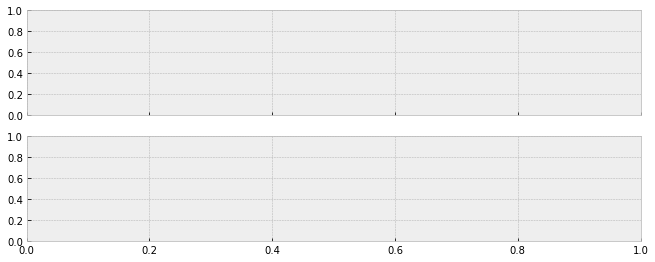

In [12]:
p1 = Timeseries1dStickPlot()
plt1, fig1 = p1.plot(timedata=data.index, 
                     udata=data.ufdata.values, 
                     vdata=data.vfdata.values,
                     rotate=0)
plt1.xlabel('test')
fig1.savefig('test_f35'+'.png',dpi=600)


#subsample
datasub=data.resample('24H').median()
p1 = Timeseries1dStickPlot()
plt1, fig1 = p1.plot(timedata=datasub.index, 
                     udata=datasub.ufdata.values, 
                     vdata=datasub.vfdata.values,
                     linescale=10,
                     rotate=0)
plt1.xlabel('test')
fig1.savefig('test_f35_12hr'+'.png',dpi=600)

p1 = Timeseries1dStickPlot()
plt1, fig1 = p1.plot(timedata=data.index, 
                     udata=data.udata.values, 
                     vdata=data.vdata.values,
                     rotate=0)
plt1.xlabel('test')
fig1.savefig('test_nofilter'+'.png',dpi=600)


### Loop through ADCP all sites

### Determine Mean, STD, Max value for each deployment

- from filtered data

M8 
- 2009/2012 ?
- no data in 2017 (failed instrument)
- 2018 not yet finalized

In [19]:
server_url='http://akutan.pmel.noaa.gov:8080/erddap'
dataset = 'ADCP_Mooring_16bsp8a_final'

e = ERDDAP(server=server_url)

df = pd.read_csv(e.get_search_url(response='csv', search_for='ADCP_Mooring and bsp8 and ADCP'))
print(df['Dataset ID'].values)

e.protocol = 'griddap'

opendap_url = e.get_download_url(
    dataset_id=dataset,
    response='opendap',
)

print(opendap_url)

['ADCP_Mooring_14bsp8a_final' 'ADCP_Mooring_16bsp8a_final'
 'ADCP_Mooring_18bsp8a_final' 'ADCP_Mooring_13bsp8a_final'
 'ADCP_Mooring_05bsp8b_final' 'ADCP_Mooring_08bsp8a_final'
 'ADCP_Mooring_05bsp8a_final' 'ADCP_Mooring_06bsp8a_final'
 'ADCP_Mooring_07bsp8a_final' 'ADCP_Mooring_11bsp8a_final'
 'ADCP_Mooring_10bsp8a_final' 'ADCP_Mooring_15bsp8a_final']
http://akutan.pmel.noaa.gov:8080/erddap/griddap/ADCP_Mooring_16bsp8a_final


In [35]:
from requests.exceptions import HTTPError
import warnings
warnings.filterwarnings('ignore')

plotfigs = False
savedata = True
domath = True

for dataset_id in sorted(df['Dataset ID'].values):
    try:
        e = ERDDAP(server=server_url,
            protocol='griddap',
            response='opendap'
        )
        e.constraints=None
        e.protocol = 'griddap'

        e.dataset_id=dataset_id
        e.response = 'nc'
        ds = e.to_xarray(decode_times=True)
    except:
        pass
    
    depth_curr = ds.isel(depth=ds.depth.size-2)
    
    ### dropna's to start (gets rid of any where all entries are gone)
    depth_curr = depth_curr.dropna(dim='time',how="all")
    
    ### filter
    udata = depth_curr.u_1205[:,0,0].to_pandas()
    vdata = depth_curr.v_1206[:,0,0].to_pandas()

    data = pd.concat([udata, vdata], axis=1)
    data.columns = ['udata','vdata']

    data['udata'][data.udata > 1e34]=np.nan
    data['vdata'][data.vdata > 1e34]=np.nan
    data = data.resample('1H').mean()

    ## missing data fill limited by number of hours to linearly interpolate
    data['tempu'] = data['udata'].interpolate(method='time',limit=6)
    data['tempv'] = data['vdata'].interpolate(method='time',limit=6)

    # get index of missing data that wasn't filled
    # the remaining missing data will continue to be missing after analysis
    # this data and the edges of the timeseries need to have the effects of the filter window accounted for

    missing_index_u = np.isnan(data.tempu)
    missing_index_v = np.isnan(data.tempv)
    data['tempu'] = data['udata'].interpolate(method='time')
    data['tempv'] = data['vdata'].interpolate(method='time')

    #filter data with rudimentary matlab script
    data['ufdata'] = lanzcos.lanzcos(data.tempu.values,1,35)+data['udata'].mean()
    data['vfdata'] = lanzcos.lanzcos(data.tempv.values,1,35)+data['vdata'].mean()
    data['ufdata'][missing_index_u] = np.nan
    data['vfdata'][missing_index_v] = np.nan    

    #extra calculations
    if domath:
        print(dataset_id)
        print(data.describe()[['ufdata','vfdata']])
        
    #plot
    if plotfigs:
        p1 = Timeseries1dStickPlot()
        plt1, fig1 = p1.plot(timedata=data.index, 
                             udata=data.ufdata.values, 
                             vdata=data.vfdata.values,
                             rotate=0)
        plt1.xlabel(dataset_id+'_f35')
        fig1.savefig(dataset_id+'_f35'+'.png',dpi=600)


        #subsample
        datasub=data.resample('D').median()
        p1 = Timeseries1dStickPlot()
        plt1, fig1 = p1.plot(timedata=datasub.index, 
                             udata=datasub.ufdata.values, 
                             vdata=datasub.vfdata.values,
                             linescale=10,
                             rotate=0)
        plt1.xlabel(dataset_id+'_f35_daily')
        fig1.savefig(dataset_id+'_f35_daily'+'.png',dpi=600)

        p1 = Timeseries1dStickPlot()
        plt1, fig1 = p1.plot(timedata=data.index, 
                             udata=data.udata.values, 
                             vdata=data.vdata.values,
                             rotate=0)
        plt1.xlabel(dataset_id+'_nofilter')
        fig1.savefig(dataset_id+'_nofilter'+'.png',dpi=600)
        
    #save data
    if savedata:
        data.to_csv(dataset_id+'_f35'+'.csv')

ADCP_Mooring_05bsp8a_final
            ufdata       vfdata
count  1788.000000  1788.000000
mean      1.567466     0.242940
std       4.273652     4.201983
min     -18.065430   -14.987763
25%      -0.788245    -2.015015
50%       2.071056     0.597495
75%       4.000924     2.619545
max      14.072985    14.288246
ADCP_Mooring_05bsp8b_final
            ufdata       vfdata
count  8798.000000  8798.000000
mean     -0.511131     0.925425
std       6.398679     5.243882
min     -29.679158   -22.298301
25%      -3.889086    -1.567718
50%      -0.713220     0.856691
75%       2.572998     3.464229
max      32.508660    21.508366
ADCP_Mooring_06bsp8a_final
            ufdata       vfdata
count  8560.000000  8560.000000
mean     -0.081710    -1.355883
std       4.465095     6.530312
min     -25.491254   -29.592387
25%      -2.398798    -4.409562
50%      -0.029908    -1.122877
75%       2.157526     2.347272
max      19.253940    25.979401
ADCP_Mooring_07bsp8a_final
            ufdata       vfd

## Backscatter from EIN files (not on erddap)

In [17]:
einfiles = '/Users/bell/ecoraid/2017/Moorings/17bsp2b/erddap/final_data/17bsp2b_wcp_ein.cf.nc'
xdf = xr.load_dataset(einfiles)

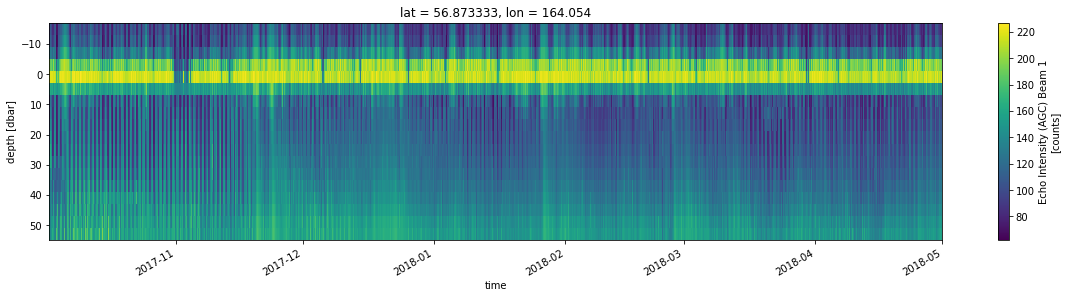

In [20]:
fig, ax = plt.subplots(figsize=(20, 4))
xdf.AGC1_1221.T.plot(ax=ax)
ax.invert_yaxis()

(17501.0, 17531.0)

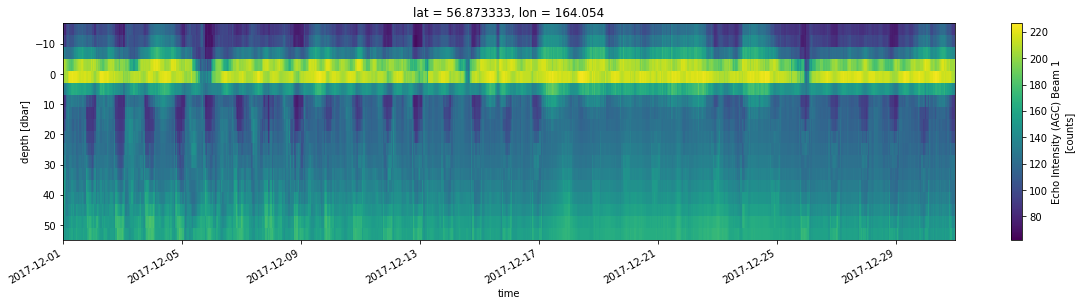

In [26]:
fig, ax = plt.subplots(figsize=(20, 4))
xdf.AGC1_1221.T.plot(ax=ax)
ax.invert_yaxis()
ax.set_xlim([datetime.date(2017,12,1),datetime.date(2017,12,31)])

(17631.0, 17638.0)

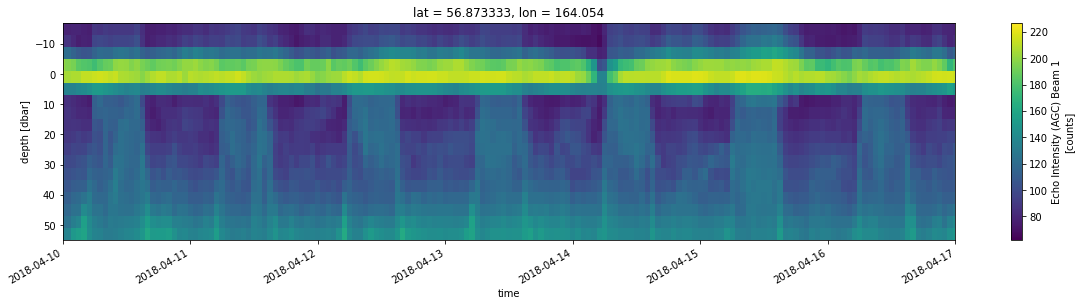

In [29]:
fig, ax = plt.subplots(figsize=(20, 4))
xdf.AGC1_1221.T.plot(ax=ax)
ax.invert_yaxis()
ax.set_xlim([datetime.date(2018,4,10),datetime.date(2018,4,17)])